In [6]:
import os
os.environ["PYTHONNOUSERSITE"]='1'
import sys
try:
    sys.path.remove('/n/home12/binxuwang/.local/lib/python3.10/site-packages',)
except ValueError:
    pass

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/n/home12/binxuwang/Github/DiffusionReasoning')

In [3]:
#%%
import os
import re
import json
import pickle as pkl
from os.path import join
from tqdm import trange, tqdm
from os.path import join
from easydict import EasyDict as edict
import numpy as np
import torch as th
import einops
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from os.path import join
from edm_utils import parse_train_logfile
from dataset_utils import onehot2attr_tsr
from stats_plot_utils import estimate_CI, shaded_error, saveallforms
from stats_plot_utils import shaded_error, add_rectangles
from rule_utils import get_rule_list, get_obj_list, get_rule_img, check_consistent
from rule_new_utils import get_rule_annot
from GPT_models.GPT_RAVEN_model_lib import MultiIdxGPT2Model, completion_eval, seqtsr2imgtsr

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
GPTroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven"

In [5]:
# expname = "GPT2_base_RAVEN_uncond_heldout0-20240515-021155"
# expname = "GPT2_big_pilot_fixed"
# expname = "GPT2_big_RAVEN_uncond_heldout0-20240515-085510"
expname = "GPT2_base_RAVEN_uncond_heldout0-20240630-023945"
expdir = join(GPTroot, expname)

In [6]:
heldout_ids = [1, 16, 20, 34, 37]

In [14]:
!du {expdir}/ckpt/* -sh

325M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven/GPT2_base_RAVEN_uncond_heldout0-20240630-023945/ckpt/gpt2_ep14.pth
325M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven/GPT2_base_RAVEN_uncond_heldout0-20240630-023945/ckpt/gpt2_ep19.pth
325M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven/GPT2_base_RAVEN_uncond_heldout0-20240630-023945/ckpt/gpt2_ep24.pth
325M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven/GPT2_base_RAVEN_uncond_heldout0-20240630-023945/ckpt/gpt2_ep29.pth
325M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven/GPT2_base_RAVEN_uncond_heldout0-20240630-023945/ckpt/gpt2_ep34.pth
325M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven/GPT2_base_RAVEN_uncond_heldout0-20240630-023945/ckpt/gpt2_ep39.pth
325M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/

In [15]:
!ls {expdir}/samples 

eval_epoch0.pt	 eval_epoch32.pt  eval_epoch55.pt  eval_epoch78.pt
eval_epoch10.pt  eval_epoch33.pt  eval_epoch56.pt  eval_epoch79.pt
eval_epoch11.pt  eval_epoch34.pt  eval_epoch57.pt  eval_epoch7.pt
eval_epoch12.pt  eval_epoch35.pt  eval_epoch58.pt  eval_epoch80.pt
eval_epoch13.pt  eval_epoch36.pt  eval_epoch59.pt  eval_epoch81.pt
eval_epoch14.pt  eval_epoch37.pt  eval_epoch5.pt   eval_epoch82.pt
eval_epoch15.pt  eval_epoch38.pt  eval_epoch60.pt  eval_epoch83.pt
eval_epoch16.pt  eval_epoch39.pt  eval_epoch61.pt  eval_epoch84.pt
eval_epoch17.pt  eval_epoch3.pt   eval_epoch62.pt  eval_epoch85.pt
eval_epoch18.pt  eval_epoch40.pt  eval_epoch63.pt  eval_epoch86.pt
eval_epoch19.pt  eval_epoch41.pt  eval_epoch64.pt  eval_epoch87.pt
eval_epoch1.pt	 eval_epoch42.pt  eval_epoch65.pt  eval_epoch88.pt
eval_epoch20.pt  eval_epoch43.pt  eval_epoch66.pt  eval_epoch89.pt
eval_epoch21.pt  eval_epoch44.pt  eval_epoch67.pt  eval_epoch8.pt
eval_epoch22.pt  eval_epoch45.pt  eval_epoch68.pt  eval_epoch90.pt

In [16]:
list(th.load(join(expdir, "samples", "eval_epoch2.pt")))

['eval_complete',
 'C3_list',
 'C2_list',
 'rule_col_list',
 'stats',
 'eval_complete_abinit',
 'C3_list_abinit',
 'C2_list_abinit',
 'rule_col_list_abinit',
 'stats_abinit']

## Individual Rule learning dynamics 

In [77]:
# demo loading code for single epoch 
data = th.load(join(expdir, "samples", "eval_epoch5.pt"))

sample_tsr = data["eval_complete"]
C3_list = data["C3_list"]
C2_list = data["C2_list"]
rule_col_list = data["rule_col_list"]

rule_col_arr = np.array(rule_col_list, dtype=object)
# cond distribution 
cond_vec = rule_col_arr[:,0].astype(int)
rule_ids, cond_counts = np.unique(cond_vec, return_counts=True)
total_count_vec = np.zeros((40,), dtype=int)
total_count_vec[rule_ids] = cond_counts

C3_total = sum([len(C3) for C3 in C3_list if len(C3)>0])
rule_pool = np.concatenate(list(C3_list)).astype(int)
rule_ids, C3_rule_counts = np.unique(rule_pool, return_counts=True)
C3_count_vec = np.zeros((40,), dtype=int)
C3_count_vec[rule_ids] = C3_rule_counts

C2_total = sum([len(C2) for C2 in C2_list if len(C2)>0])
rule_pool = np.concatenate(list(C2_list)).astype(int)
rule_ids, C2_rule_counts = np.unique(rule_pool, return_counts=True)
C2_count_vec = np.zeros((40,), dtype=int)
C2_count_vec[rule_ids] = C2_rule_counts

### Prep the utils function

In [12]:
def visualize_indiv_rule_dynam(epoch_list, rule_mat, conv_wid=10, heldout_id=[1, 16, 20, 34, 37],
                               titlestr="Valid rule count separated by rule type", ylabel="Count", axs=None):
    # remove top and right spines from plot with plt
    plt.rcParams.update({'font.size': 12})
    if axs is None:
        figh, axs = plt.subplots(4, 10, figsize=(30, 12.5), sharex=True, sharey=True)
    else:
        figh = axs[0,0].get_figure()
    axs_f = axs.flatten()
    for i in range(40):
        ax = axs_f[i]
        # smooth the curve
        smooth_rule_cnt = np.convolve(rule_mat[:,i], np.ones(conv_wid)/conv_wid, mode='same')
        ax.plot(epoch_list, smooth_rule_cnt, alpha=0.7, )
        ax.set_title(f"R{i}: {rule_table[i]}")
        # change the font color of title to red
        if i in heldout_id:
            ax.title.set_color('red')
        if i >= 30:
            ax.set_xlabel("generation")
        if i % 10 == 0:
            ax.set_ylabel(ylabel)
    figh.suptitle(titlestr, fontsize=20)
    figh.tight_layout()
    figh.show()
    return figh, axs

rule_table, relation_dict, attribute_dict = get_rule_annot()

### Evaluate the dynamics of rule completion task

In [11]:
total_count_mat = []
C3_count_mat = []
C2_count_mat = []
for epoch in trange(100):
    data = th.load(join(expdir, "samples", f"eval_epoch{epoch}.pt"))
    
    sample_tsr = data["eval_complete"]
    C3_list = data["C3_list"]
    C2_list = data["C2_list"]
    rule_col_list = data["rule_col_list"]

    rule_col_arr = np.array(rule_col_list, dtype=object)
    # number of prompts following each rule. 
    cond_vec = rule_col_arr[:,0].astype(int)
    rule_ids, cond_counts = np.unique(cond_vec, return_counts=True)
    total_count_vec = np.zeros((40,), dtype=int)
    total_count_vec[rule_ids] = cond_counts

    C3_total = sum([len(C3) for C3 in C3_list if len(C3)>0])
    rule_pool = np.concatenate(list(C3_list)).astype(int)
    rule_ids, C3_rule_counts = np.unique(rule_pool, return_counts=True)
    C3_count_vec = np.zeros((40,), dtype=int)
    C3_count_vec[rule_ids] = C3_rule_counts

    C2_total = sum([len(C2) for C2 in C2_list if len(C2)>0])
    rule_pool = np.concatenate(list(C2_list)).astype(int)
    rule_ids, C2_rule_counts = np.unique(rule_pool, return_counts=True)
    C2_count_vec = np.zeros((40,), dtype=int)
    C2_count_vec[rule_ids] = C2_rule_counts
    total_count_mat.append(total_count_vec)
    C3_count_mat.append(C3_count_vec)
    C2_count_mat.append(C2_count_vec)
total_count_mat = np.array(total_count_mat)
C3_count_mat = np.array(C3_count_mat)
C2_count_mat = np.array(C2_count_mat)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2240006/1168214544.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cond_vec = rule_col_arr[:,0].astype(int)
100%|██████████| 100/100 [00:10<00:00,  9.22it/s]


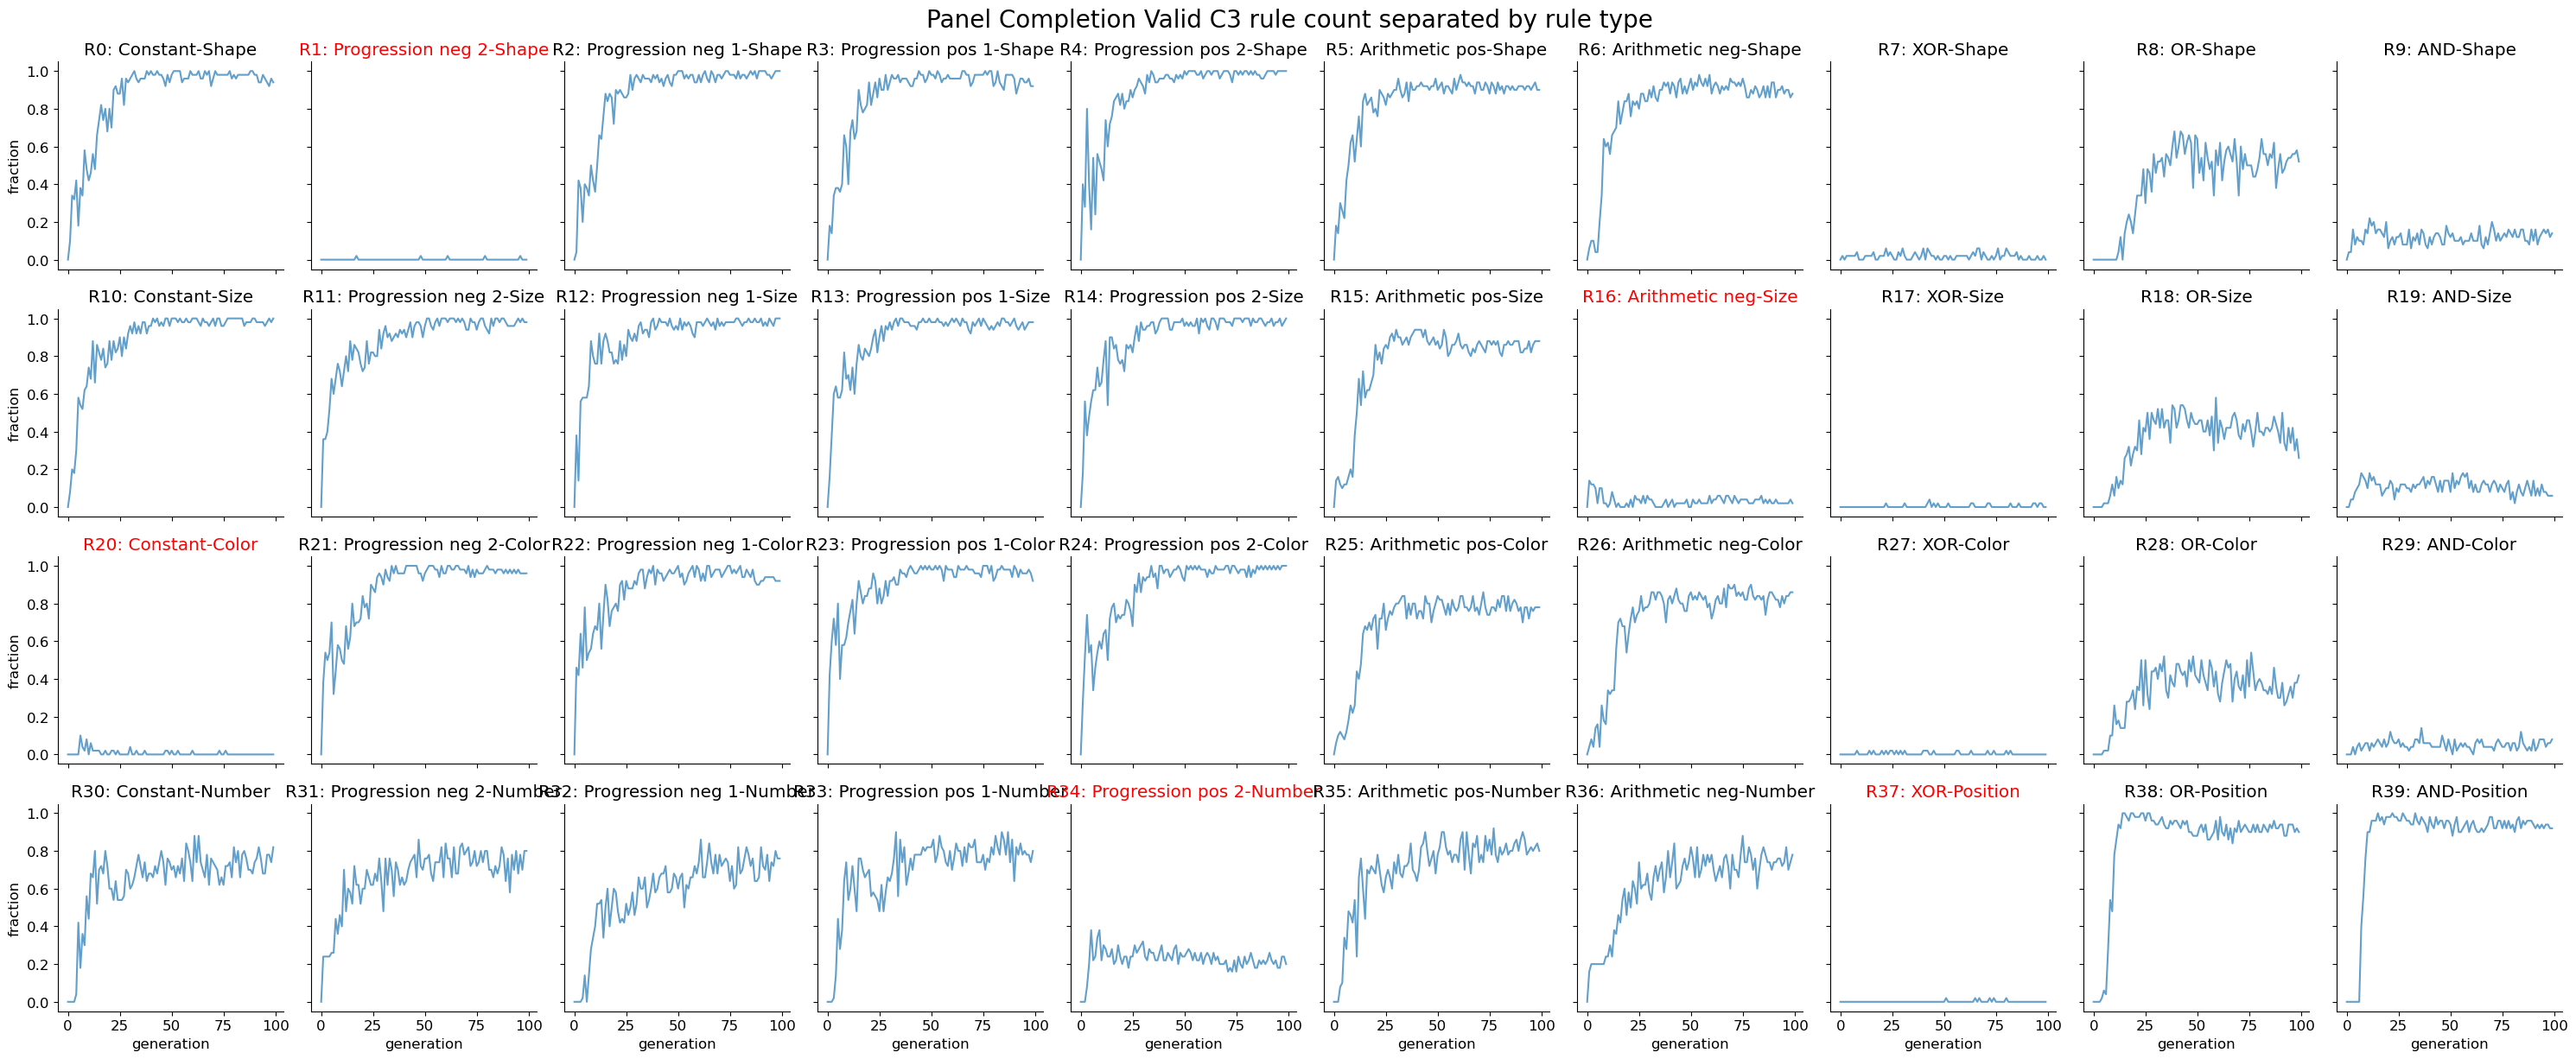

In [21]:
figh, axs = visualize_indiv_rule_dynam(range(100), C3_count_mat / total_count_mat, conv_wid=1, heldout_id=[1, 16, 20, 34, 37], 
                                       titlestr="Panel Completion Valid C3 rule count separated by rule type", ylabel="fraction")

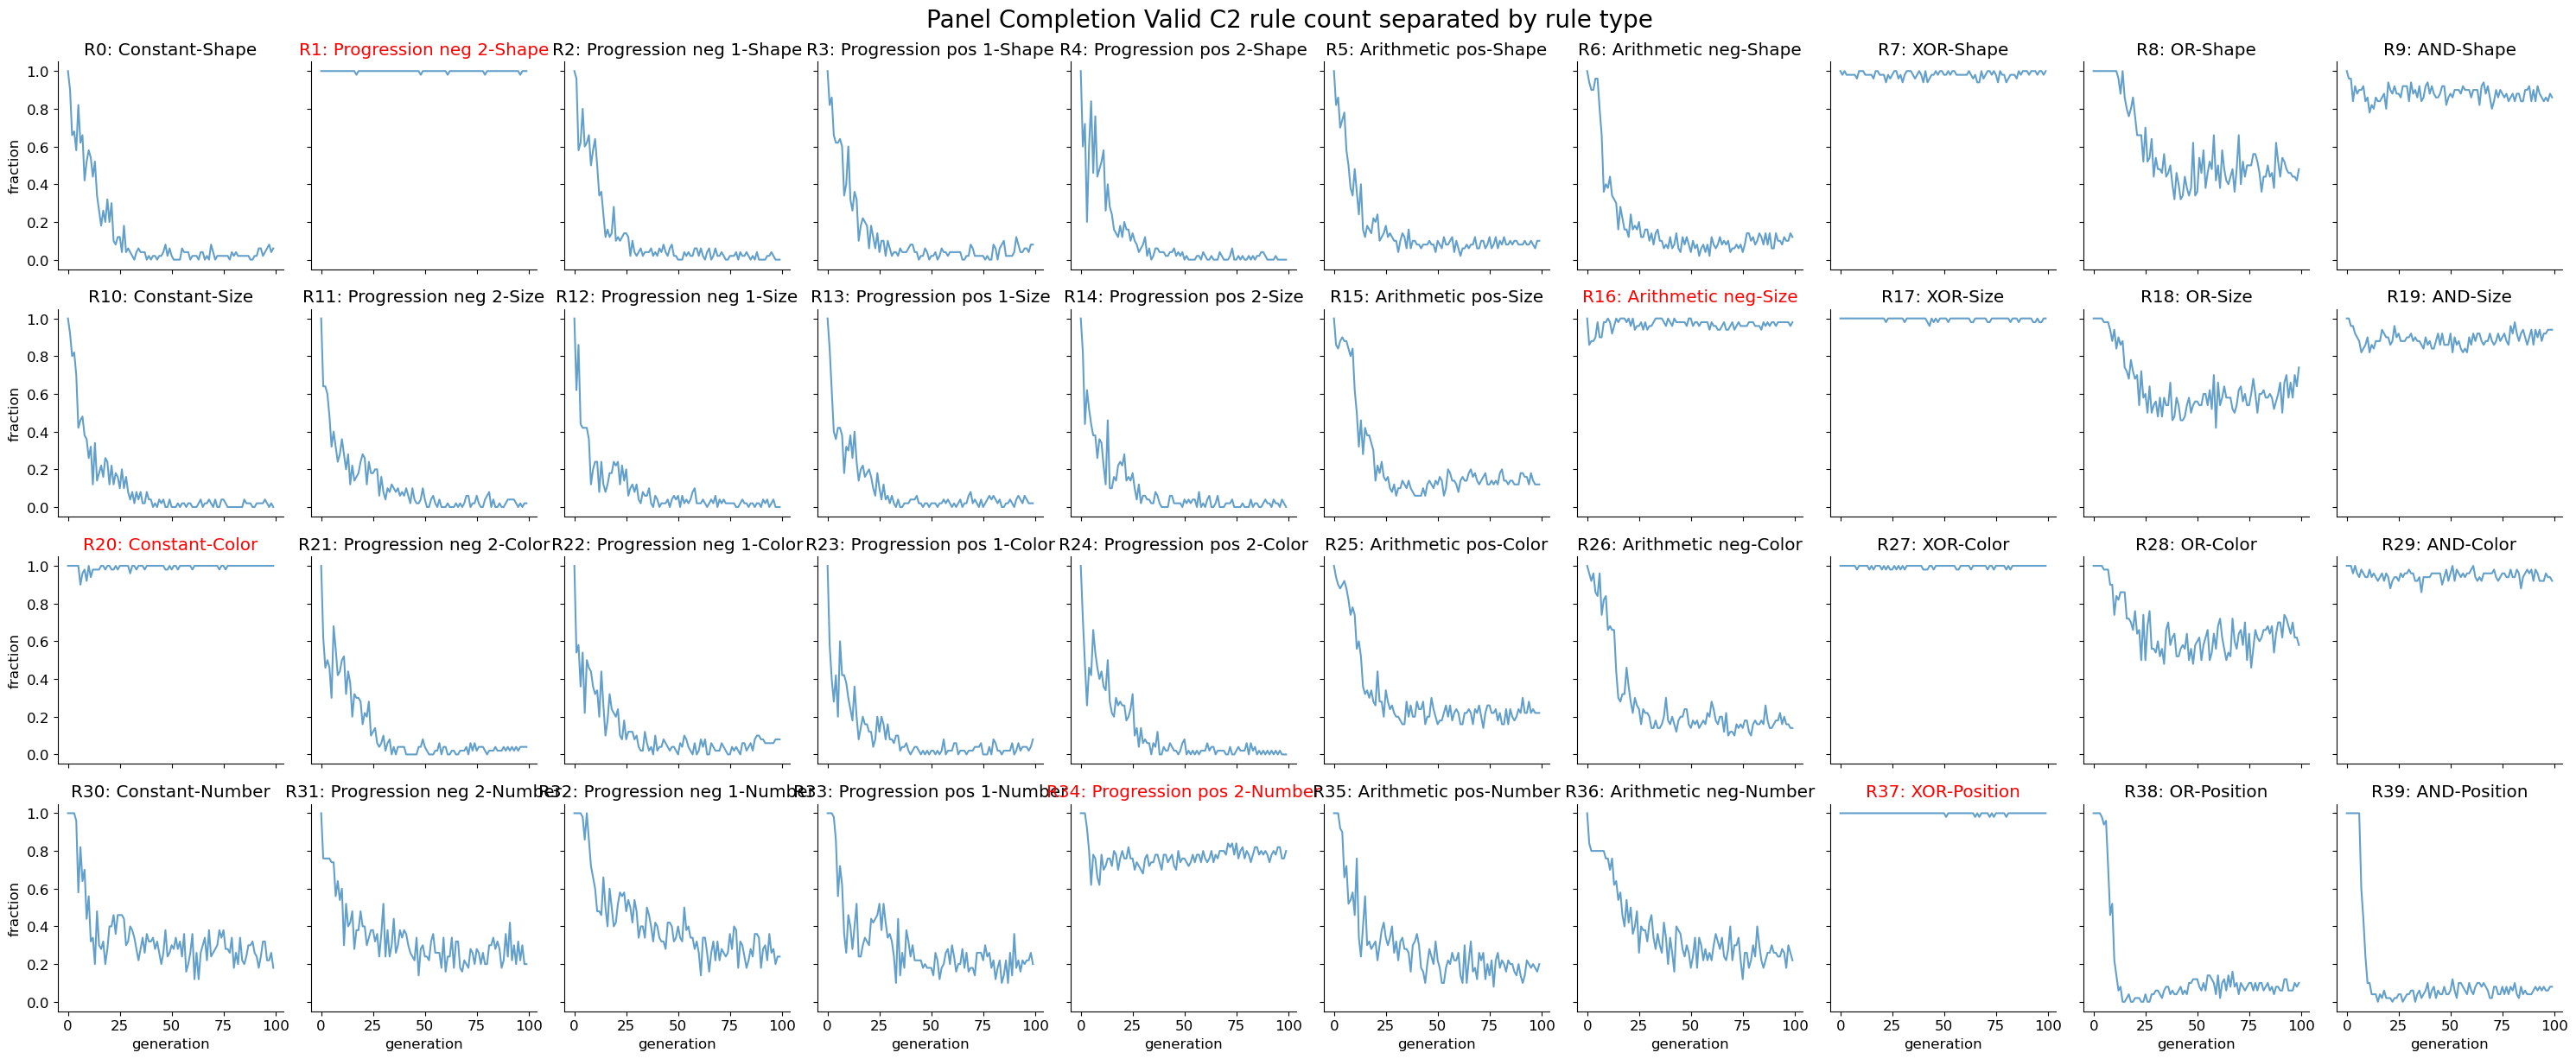

In [22]:
figh, axs = visualize_indiv_rule_dynam(range(100), (C2_count_mat) / total_count_mat, conv_wid=1, heldout_id=[1, 16, 20, 34, 37], 
                                       titlestr="Panel Completion Valid C2 rule count separated by rule type", ylabel="fraction")

In [17]:
1E6 * 256 /40

6400000.0

### Visualize final epoch accuracy per rule

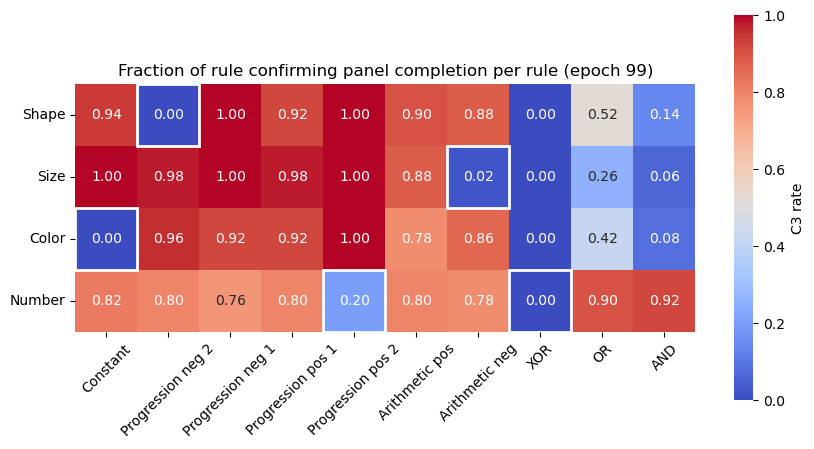

In [21]:
epoch = 99
C3_rate_vec = C3_count_mat[epoch] / total_count_mat[epoch]
plt.figure(figsize=(10,5))
sns.heatmap(C3_rate_vec.reshape(4,10), annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'C3 rate'},)
plt.title(f"Fraction of rule confirming panel completion per rule (epoch {epoch})")
plt.xticks(ticks=np.arange(10)+0.5, labels=[relation_dict[i] for i in range(10)], rotation=45)
plt.yticks(ticks=np.arange(4)+0.5, labels=[attribute_dict[i] for i in range(4)], rotation=0)
add_rectangles(heldout_ids, edgecolor="white")
plt.axis("image")
plt.show()

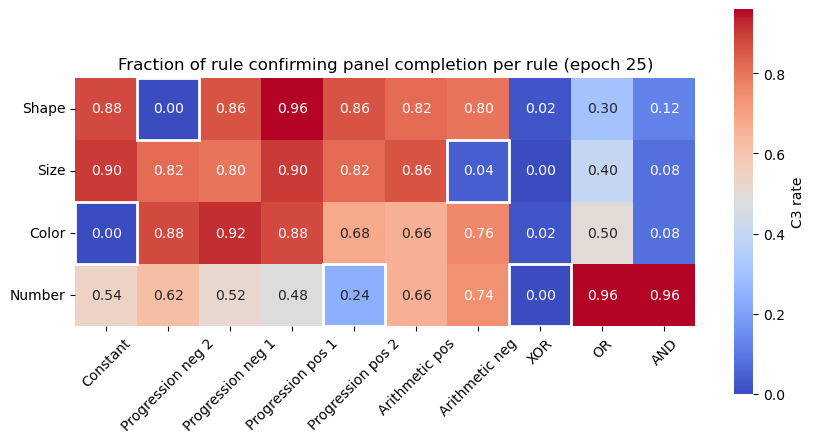

In [24]:
epoch = 25
C3_rate_vec = C3_count_mat[epoch] / total_count_mat[epoch]
plt.figure(figsize=(10,5))
sns.heatmap(C3_rate_vec.reshape(4,10), annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'C3 rate'},)
plt.title(f"Fraction of rule confirming panel completion per rule (epoch {epoch})")
plt.xticks(ticks=np.arange(10)+0.5, labels=[relation_dict[i] for i in range(10)], rotation=45)
plt.yticks(ticks=np.arange(4)+0.5, labels=[attribute_dict[i] for i in range(4)], rotation=0)
add_rectangles(heldout_ids, edgecolor="white")
plt.axis("image")
plt.show()

### Evaluate the dynamics of ab init generation task

In [36]:
valid_abinit_count_mat = []
C3_abinit_count_mat = []
C2_abinit_count_mat = []
for epoch in trange(100):
    data = th.load(join(expdir, "samples", f"eval_epoch{epoch}.pt"))
    
    sample_tsr = data["eval_complete_abinit"]
    C3_list = data["C3_list_abinit"]
    C2_list = data["C2_list_abinit"]
    rule_col_list = data["rule_col_list_abinit"]

    rule_col_arr = np.array(rule_col_list, dtype=object)
    # number of prompts following each rule. 
    row_rule_vec = np.concatenate(list(rule_col_arr[:,:].flatten())).astype(int)
    # row_rule_vec = rule_col_arr[:,:].astype(int)
    rule_ids, cond_counts = np.unique(row_rule_vec, return_counts=True)
    valid_count_vec = np.zeros((40,), dtype=int)
    valid_count_vec[rule_ids] = cond_counts

    C3_total = sum([len(C3) for C3 in C3_list if len(C3)>0])
    rule_pool = np.concatenate(list(C3_list)).astype(int)
    rule_ids, C3_rule_counts = np.unique(rule_pool, return_counts=True)
    C3_count_vec = np.zeros((40,), dtype=int)
    C3_count_vec[rule_ids] = C3_rule_counts

    C2_total = sum([len(C2) for C2 in C2_list if len(C2)>0])
    rule_pool = np.concatenate(list(C2_list)).astype(int)
    rule_ids, C2_rule_counts = np.unique(rule_pool, return_counts=True)
    C2_count_vec = np.zeros((40,), dtype=int)
    C2_count_vec[rule_ids] = C2_rule_counts
    
    valid_abinit_count_mat.append(valid_count_vec)
    C3_abinit_count_mat.append(C3_count_vec)
    C2_abinit_count_mat.append(C2_count_vec)
valid_abinit_count_mat = np.array(valid_abinit_count_mat)
C3_abinit_count_mat = np.array(C3_abinit_count_mat)
C2_abinit_count_mat = np.array(C2_abinit_count_mat)

100%|██████████| 100/100 [00:07<00:00, 14.10it/s]


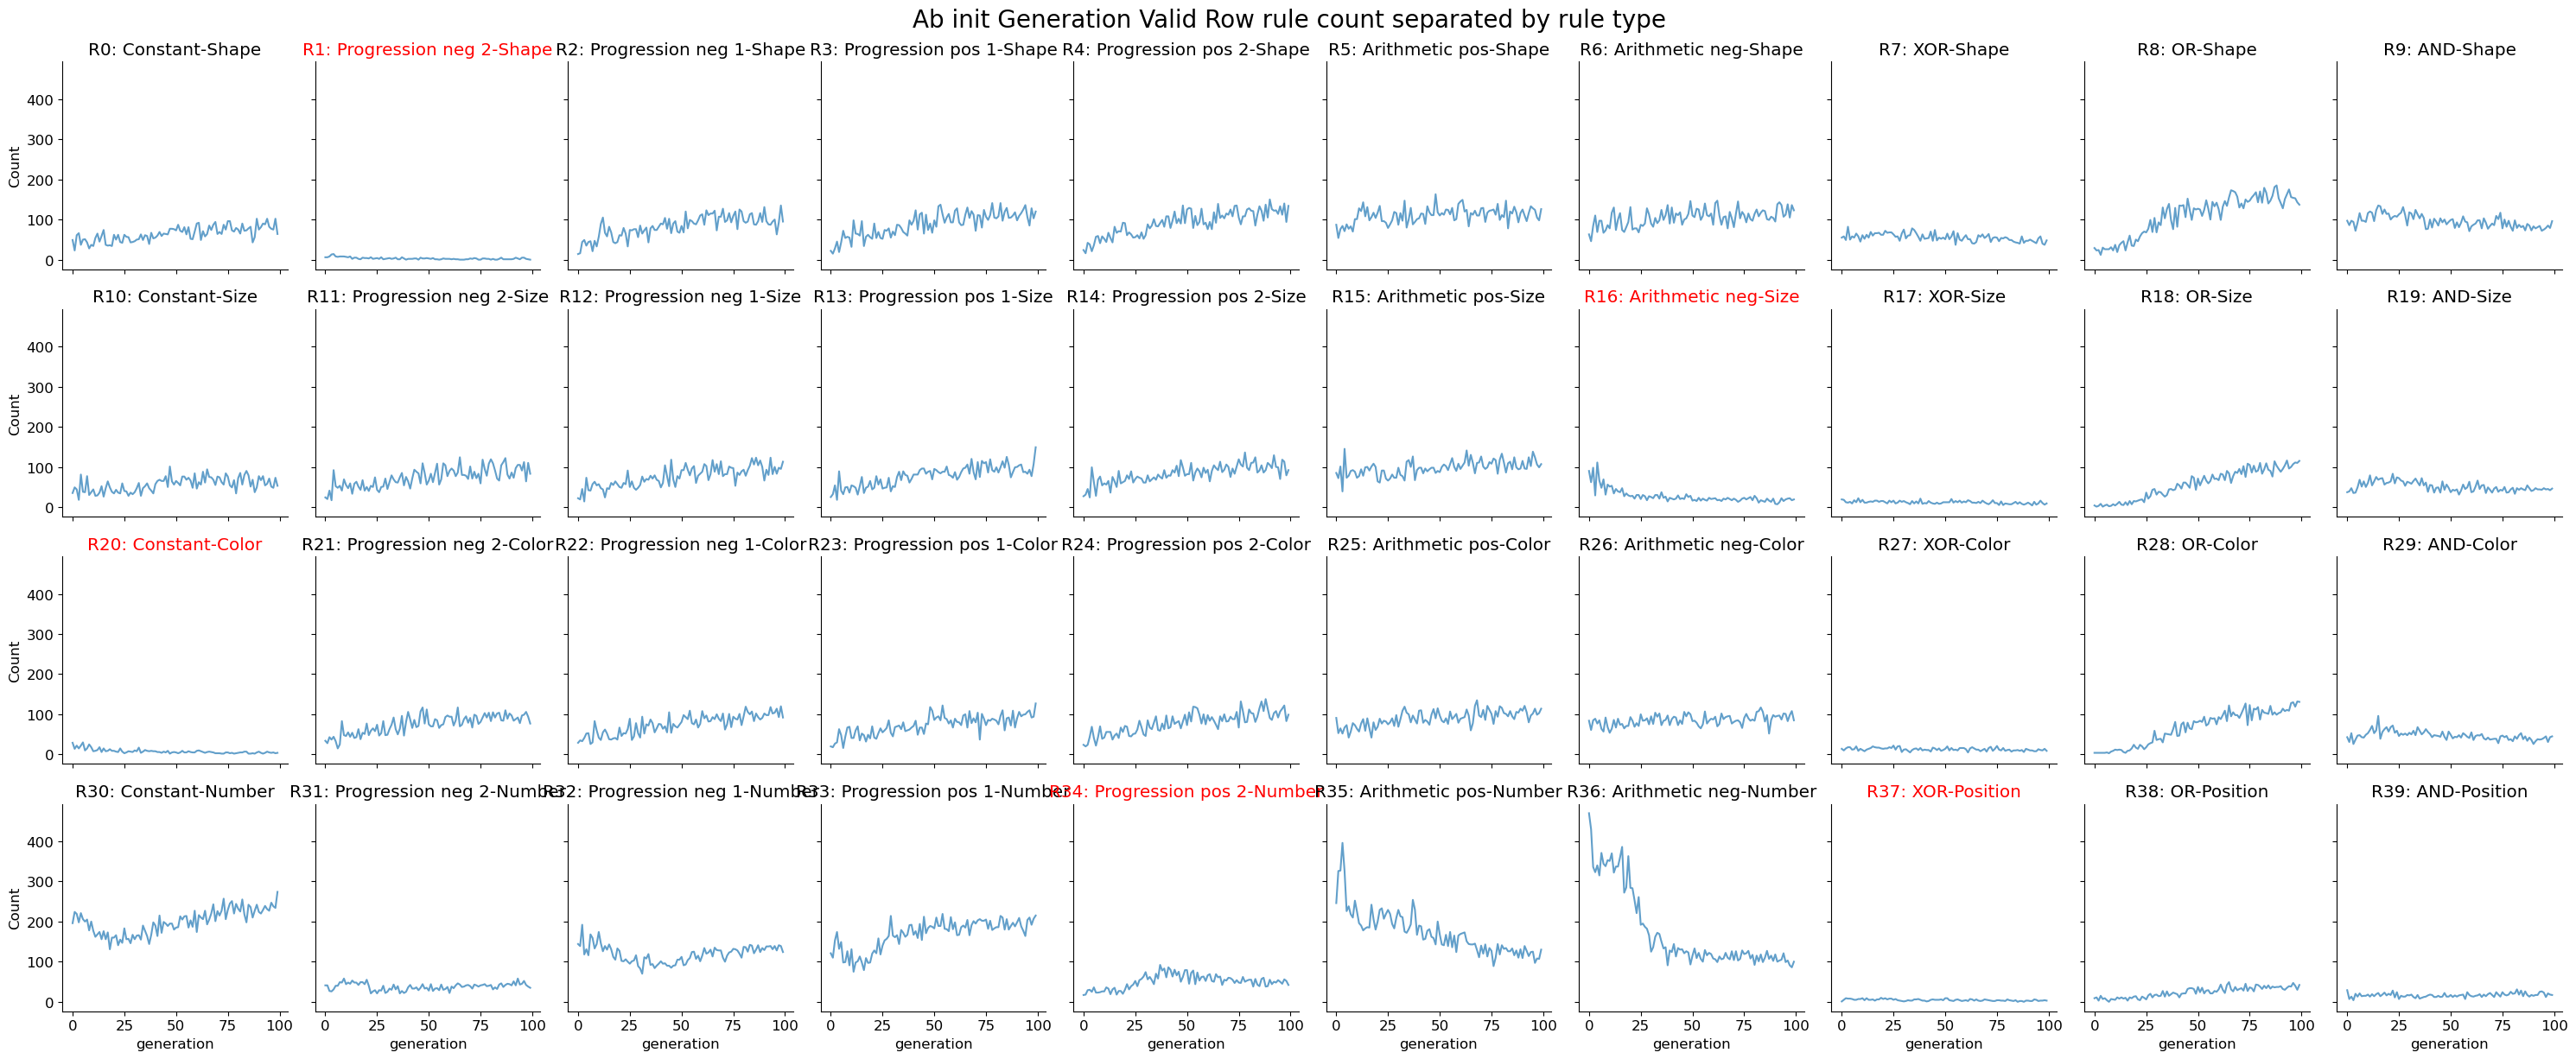

In [37]:
figh, axs = visualize_indiv_rule_dynam(range(100), valid_abinit_count_mat, conv_wid=1, heldout_id=[1, 16, 20, 34, 37], 
                                       titlestr="Ab init Generation Valid Row rule count separated by rule type", ylabel="Count")

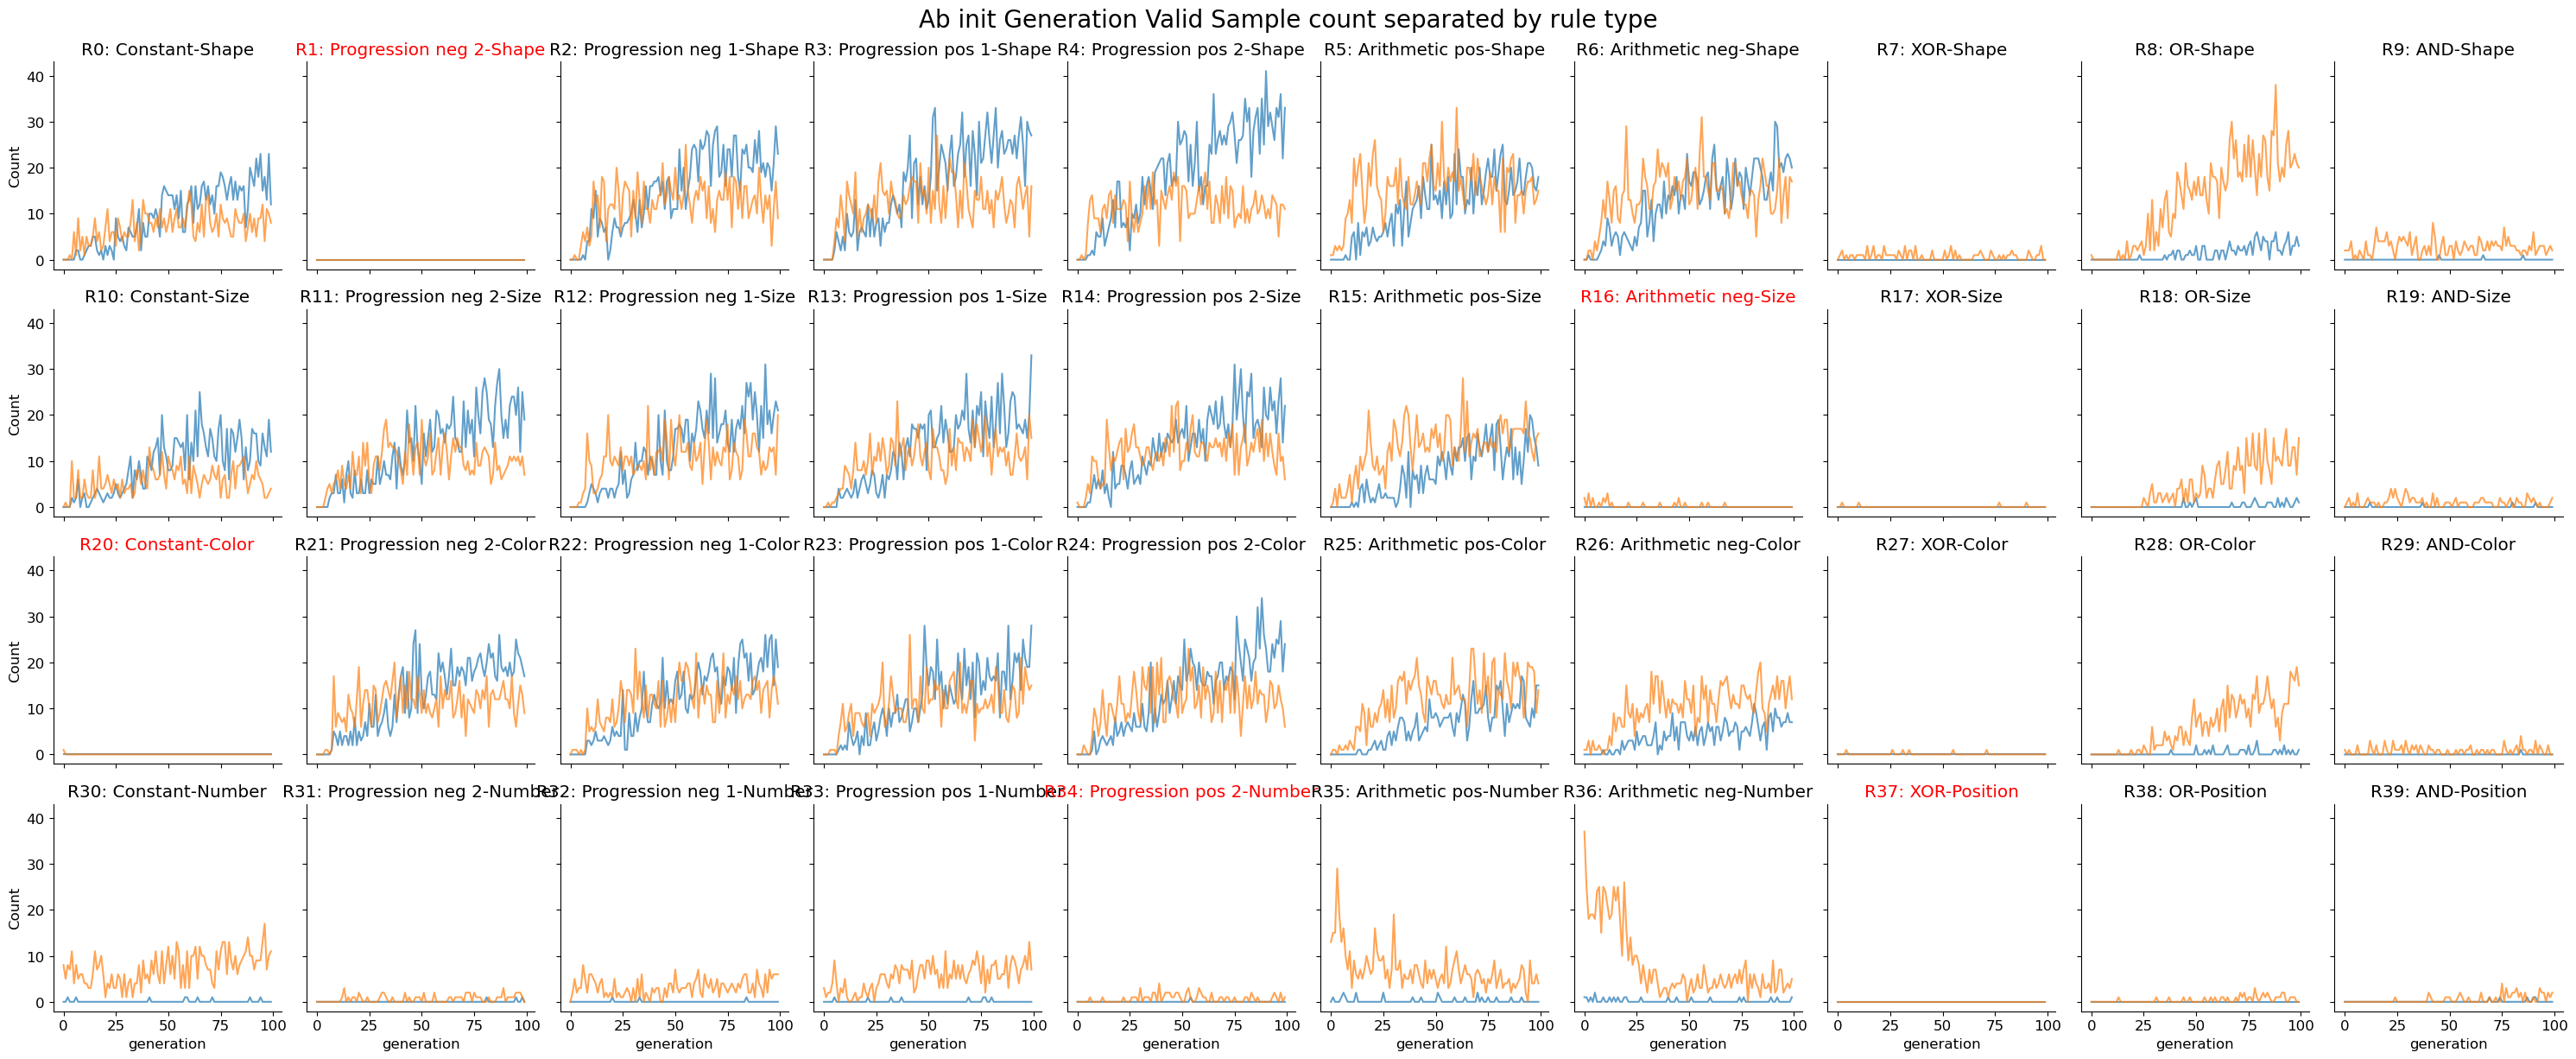

In [38]:
figh, axs = visualize_indiv_rule_dynam(range(100), C3_abinit_count_mat, conv_wid=1, heldout_id=[1, 16, 20, 34, 37], 
                                       titlestr="Ab init Generation Valid Sample count separated by rule type", ylabel="Count")
figh, axs = visualize_indiv_rule_dynam(range(100), C2_abinit_count_mat, conv_wid=1, heldout_id=[1, 16, 20, 34, 37], 
                                       titlestr="Ab init Generation Valid Sample count separated by rule type", ylabel="Count",axs=axs)

## Memorization 

In [7]:
tabdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Tables"
figdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Figures_newrule"

GPT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven"
DiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
SSM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Mamba_raven"
EDM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"

In [8]:
# figroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning"
GPTfigdir = join(figroot, "GPT2_raven")
EDMfigdir = join(figroot, "EDM_raven")
DiTfigdir = join(figroot, "DiT_raven")
SSMfigdir = join(figroot, "SSM_raven")
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/memorization_dynamics"

### Load the samples

In [ ]:
from eval_memorization_utils import eval_memorization_all_level_sample_tsr, get_RAVEN_dataset, extract_row_mat_set, extract_panel_mat_set, extract_attr_row_mat_set, extract_attr_panel_mat_set, \
    compute_memorization_tab_through_training, visualize_memorization_dynamics, compute_memorization_binary_joint, extract_training_set_row_panel_sets
from posthoc_analysis_utils import sweep_collect_sample, sweep_collect_eval_data, extract_rule_list_from_eval_col, format_rule_list_to_mat, extract_and_convert

In [22]:
syndf_GPT = pd.read_csv(join(tabdir, "GPT_raven_tensorboard_data_last10.csv"), index_col=0)
tb_data_col = pkl.load(open(join(tabdir, "GPT2_raven_tensorboard_raw_data.pkl"), "rb"))

### Success run

In [79]:
syndf_GPT.query("step > 900000").loc["GPT2_medium_uncond_heldout0_stream0_16M"].full_name

'GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019/tensorboard_logs'

In [80]:
# for expfullname in tb_data_col.keys():
expfullname = 'GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019/tensorboard_logs'
print(expfullname)
expname = expfullname.split("/tensorboard_logs")[0]
figexpdir = join(figroot, expname)
os.makedirs(figexpdir, exist_ok=True)
prefix = "eval_step" if "stream" in expname else "eval_epoch"
eval_col = sweep_collect_eval_data(expname, GPT_exproot, prefix=prefix)
sample_col = {epoch: seqtsr2imgtsr(epoch_stats['eval_complete_abinit'], h=3, w=3, p=3, R=3) for epoch, epoch_stats in eval_col.items()}
dataset_size = extract_and_convert(expname)
examples_per_rule = int(dataset_size * 1E6 / 40)
print(f"examples_per_rule: {examples_per_rule}")
# epoch_list, rule_list_all, consistency_all = extract_rule_list_from_eval_col(eval_col, is_abinit=True) # note set is_abinit to True
# rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all, consistency_all)

GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019/tensorboard_logs
Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven/GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019/samples
example file: eval_step704999.pt


  0%|          | 0/401 [00:00<?, ?it/s]

examples_per_rule: 4000


In [81]:
train_tsr_X, train_tsr_y = get_RAVEN_dataset(n_classes=40, cmb_per_class=examples_per_rule, heldout_ids=(), cmb_offset=0, cache=True)
train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col = extract_training_set_row_panel_sets(train_tsr_X)

In [87]:
ctrl_tsr_X, ctrl_tsr_y = get_RAVEN_dataset(n_classes=40, cmb_per_class=examples_per_rule, heldout_ids=heldout_ids, cmb_offset=20000, cache=True)
ctrl_X_sample_set, ctrl_X_row_set, ctrl_X_panel_set, ctrl_X_row_set_attr_col, ctrl_X_panel_set_attr_col = extract_training_set_row_panel_sets(ctrl_tsr_X)

In [83]:
mem_stats_df = compute_memorization_tab_through_training(sample_col, eval_col, train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col, abinit=True)
mem_stats_df.to_csv(join(figexpdir, "memorization_stats_train_set.csv"))

  0%|          | 0/401 [00:00<?, ?it/s]

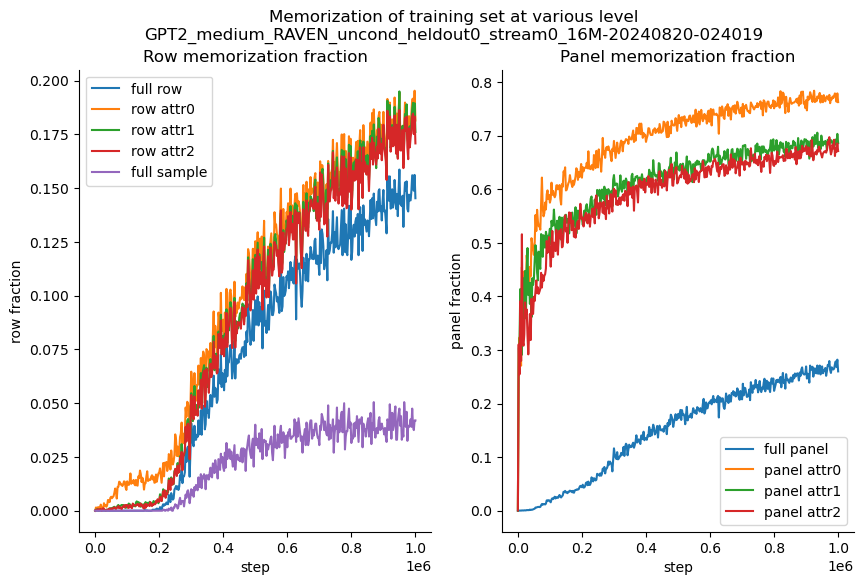

In [84]:
figh = visualize_memorization_dynamics(mem_stats_df, expname=expname)
figh.savefig(join(figexpdir, "memorization_dynamics_train_set.png"))

In [88]:
mem_stats_ctrl_df = compute_memorization_tab_through_training(sample_col, eval_col, ctrl_X_sample_set, ctrl_X_row_set, ctrl_X_panel_set, ctrl_X_row_set_attr_col, ctrl_X_panel_set_attr_col, abinit=True)
mem_stats_ctrl_df.to_csv(join(figexpdir, "memorization_stats_ctrl_set.csv"))

  0%|          | 0/401 [00:00<?, ?it/s]

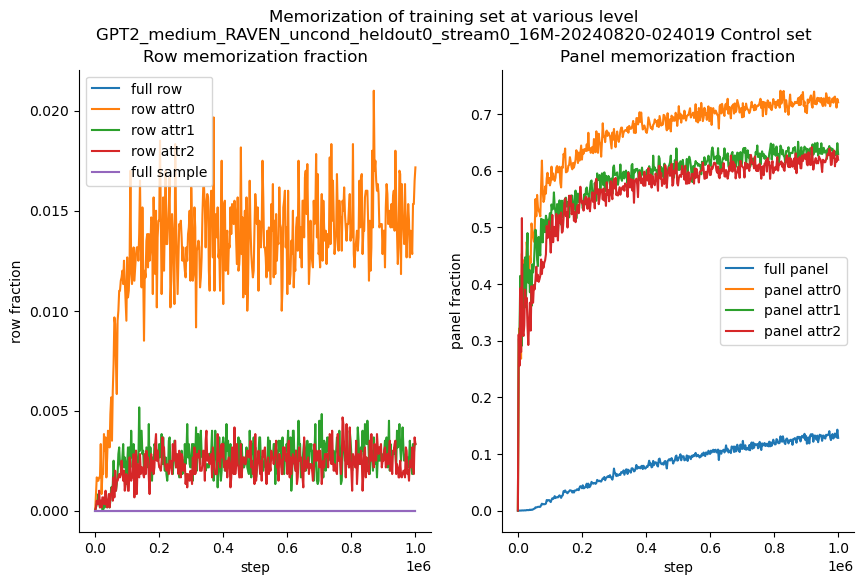

In [89]:
figh2 = visualize_memorization_dynamics(mem_stats_ctrl_df, expname=expname+' Control set')
saveallforms(figexpdir, "memorization_dynamics_ctrl_set", figh2)

### Collapsed run

In [63]:
train_tsr_X, train_tsr_y = get_RAVEN_dataset(n_classes=40, cmb_per_class=400, heldout_ids=(), cmb_offset=0, cache=True)
train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col = extract_training_set_row_panel_sets(train_tsr_X)

In [71]:
ctrl_tsr_X, ctrl_tsr_y = get_RAVEN_dataset(n_classes=40, cmb_per_class=400, heldout_ids=(), cmb_offset=20000, cache=True)
ctrl_X_sample_set, ctrl_X_row_set, ctrl_X_panel_set, ctrl_X_row_set_attr_col, ctrl_X_panel_set_attr_col = extract_training_set_row_panel_sets(ctrl_tsr_X)

In [55]:
syndf_GPT.query("step > 900000").loc["GPT2_medium_uncond_heldout0_stream0_016M"].full_name

'GPT2_medium_RAVEN_uncond_heldout0_stream0_016M-20240820-024735/tensorboard_logs'

In [56]:
# for expfullname in tb_data_col.keys():
expfullname = 'GPT2_medium_RAVEN_uncond_heldout0_stream0_016M-20240820-024735/tensorboard_logs'
print(expfullname)
expname = expfullname.split("/tensorboard_logs")[0]
figexpdir = join(figroot, expname)
os.makedirs(figexpdir, exist_ok=True)
prefix = "eval_step" if "stream" in expname else "eval_epoch"
eval_col = sweep_collect_eval_data(expname, GPT_exproot, prefix=prefix)
sample_col = {epoch: seqtsr2imgtsr(epoch_stats['eval_complete_abinit'], h=3, w=3, p=3, R=3) for epoch, epoch_stats in eval_col.items()}
# epoch_list, rule_list_all, consistency_all = extract_rule_list_from_eval_col(eval_col, is_abinit=True) # note set is_abinit to True
# rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all, consistency_all)

GPT2_medium_RAVEN_uncond_heldout0_stream0_016M-20240820-024735/tensorboard_logs
Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven/GPT2_medium_RAVEN_uncond_heldout0_stream0_016M-20240820-024735/samples
example file: eval_step704999.pt


  0%|          | 0/401 [00:00<?, ?it/s]

(401, 2000, 3) (401, 2, 2000)


In [65]:
mem_stats_df = compute_memorization_tab_through_training(sample_col, eval_col, train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col, abinit=True)

  0%|          | 0/401 [00:00<?, ?it/s]

In [72]:
mem_stats_df.to_csv(join(figexpdir, "memorization_stats_train_set.csv"))

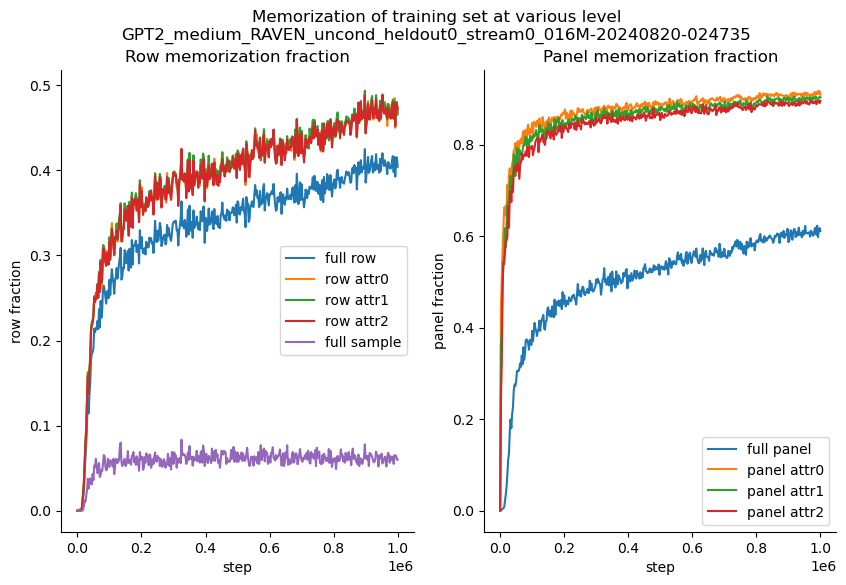

In [70]:
figh = visualize_memorization_dynamics(mem_stats_df, expname=expname)
saveallforms(figexpdir, "memorization_dynamics_train_set", figh)

In [73]:
mem_stats_ctrl_df = compute_memorization_tab_through_training(sample_col, eval_col, ctrl_X_sample_set, ctrl_X_row_set, ctrl_X_panel_set, ctrl_X_row_set_attr_col, ctrl_X_panel_set_attr_col, abinit=True)
mem_stats_ctrl_df.to_csv(join(figexpdir, "memorization_stats_ctrl_set.csv"))

  0%|          | 0/401 [00:00<?, ?it/s]

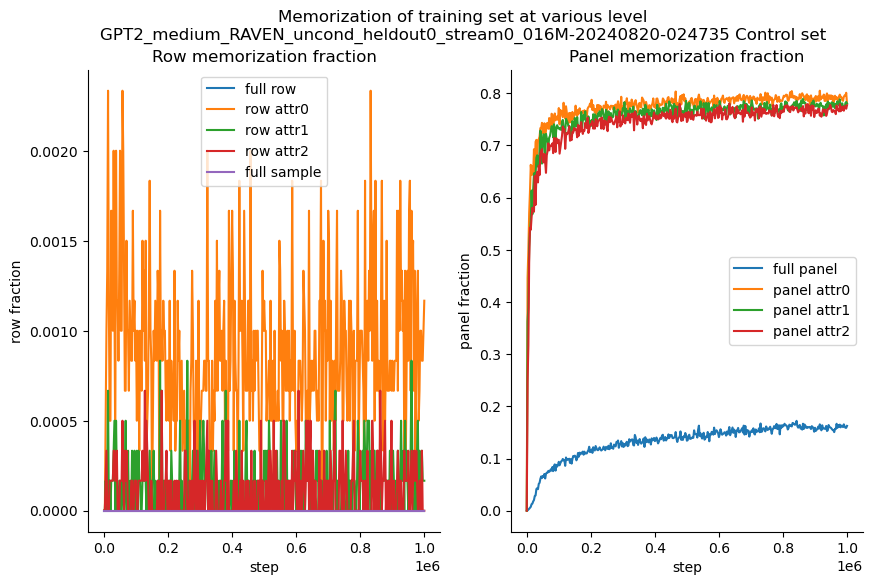

In [74]:
figh2 = visualize_memorization_dynamics(mem_stats_ctrl_df, expname=expname+' Control set')
saveallforms(figexpdir, "memorization_dynamics_ctrl_set", figh2)

### Mass produce

In [92]:
success_syndf = syndf_GPT.query("step > 900000")
len(success_syndf)

13

In [94]:
success_syndf.full_name

run_name
GPT2_base_uncond_heldout0_stream0_016M      GPT2_base_RAVEN_uncond_heldout0_stream0_016M-2...
GPT2_base_uncond_heldout0_stream0_16M       GPT2_base_RAVEN_uncond_heldout0_stream0_16M-20...
GPT2_base_uncond_heldout0_stream16M         GPT2_base_RAVEN_uncond_heldout0_stream16M-2024...
GPT2_base_uncond_heldout0_stream1_6M        GPT2_base_RAVEN_uncond_heldout0_stream1_6M-202...
GPT2_medium_uncond_heldout0_stream0_016M    GPT2_medium_RAVEN_uncond_heldout0_stream0_016M...
GPT2_medium_uncond_heldout0_stream0_16M     GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-...
GPT2_medium_uncond_heldout0_stream16M       GPT2_medium_RAVEN_uncond_heldout0_stream16M-20...
GPT2_medium_uncond_heldout0_stream1_6M      GPT2_medium_RAVEN_uncond_heldout0_stream1_6M-2...
GPT2_small_uncond_heldout0_stream0_016M     GPT2_small_RAVEN_uncond_heldout0_stream0_016M-...
GPT2_small_uncond_heldout0_stream0_16M      GPT2_small_RAVEN_uncond_heldout0_stream0_16M-2...
GPT2_small_uncond_heldout0_stream16M        GPT2_sm

GPT2_base_RAVEN_uncond_heldout0_stream0_016M-20240820-023934/tensorboard_logs
Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven/GPT2_base_RAVEN_uncond_heldout0_stream0_016M-20240820-023934/samples
example file: eval_step704999.pt


  0%|          | 0/401 [00:00<?, ?it/s]

examples_per_rule: 400


  0%|          | 0/401 [00:00<?, ?it/s]

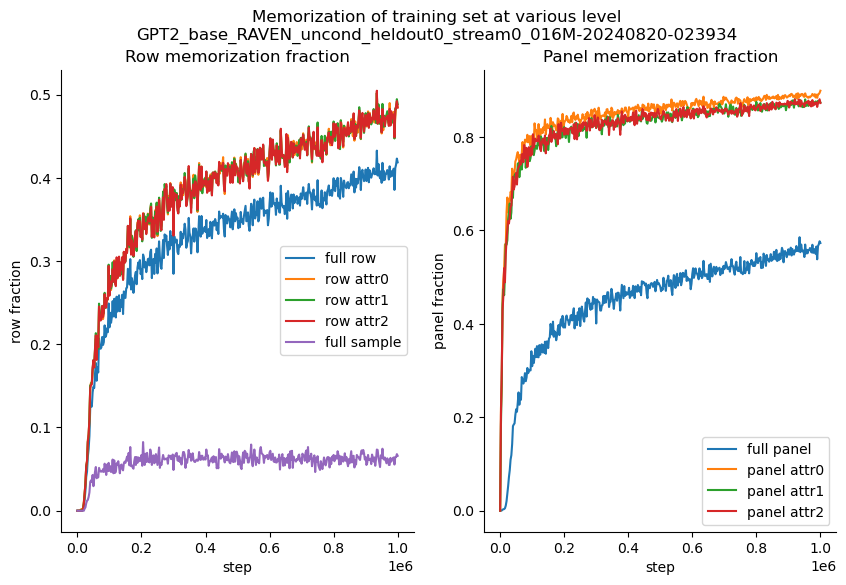

  0%|          | 0/401 [00:00<?, ?it/s]

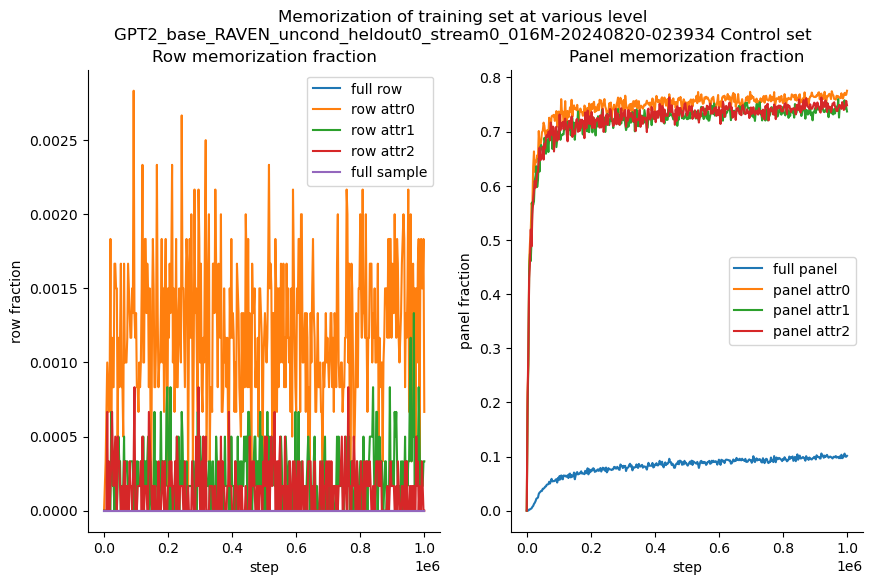

GPT2_base_RAVEN_uncond_heldout0_stream0_16M-20240820-024013/tensorboard_logs
Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven/GPT2_base_RAVEN_uncond_heldout0_stream0_16M-20240820-024013/samples
example file: eval_step704999.pt


  0%|          | 0/401 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [95]:
success_syndf = syndf_GPT.query("step > 900000")
expfullname = 'GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019/tensorboard_logs'
for expfullname in success_syndf.full_name.values:
    print(expfullname)
    expname = expfullname.split("/tensorboard_logs")[0]
    figexpdir = join(figroot, expname)
    os.makedirs(figexpdir, exist_ok=True)
    prefix = "eval_step" if "stream" in expname else "eval_epoch"
    eval_col = sweep_collect_eval_data(expname, GPT_exproot, prefix=prefix)
    sample_col = {epoch: seqtsr2imgtsr(epoch_stats['eval_complete_abinit'], h=3, w=3, p=3, R=3) for epoch, epoch_stats in eval_col.items()}
    dataset_size = extract_and_convert(expname)
    examples_per_rule = int(dataset_size * 1E6 / 40)
    print(f"examples_per_rule: {examples_per_rule}")
    # epoch_list, rule_list_all, consistency_all = extract_rule_list_from_eval_col(eval_col, is_abinit=True) # note set is_abinit to True
    # rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all, consistency_all)

    train_tsr_X, train_tsr_y = get_RAVEN_dataset(n_classes=40, cmb_per_class=examples_per_rule, heldout_ids=(), cmb_offset=0, cache=True)
    train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col = extract_training_set_row_panel_sets(train_tsr_X)

    ctrl_tsr_X, ctrl_tsr_y = get_RAVEN_dataset(n_classes=40, cmb_per_class=examples_per_rule, heldout_ids=heldout_ids, cmb_offset=20000, cache=True)
    ctrl_X_sample_set, ctrl_X_row_set, ctrl_X_panel_set, ctrl_X_row_set_attr_col, ctrl_X_panel_set_attr_col = extract_training_set_row_panel_sets(ctrl_tsr_X)

    mem_stats_df = compute_memorization_tab_through_training(sample_col, eval_col, train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col, abinit=True)
    mem_stats_df.to_csv(join(figexpdir, "memorization_stats_train_set.csv"))
    figh = visualize_memorization_dynamics(mem_stats_df, expname=expname)
    figh.savefig(join(figexpdir, "memorization_dynamics_train_set.png"))

    mem_stats_ctrl_df = compute_memorization_tab_through_training(sample_col, eval_col, ctrl_X_sample_set, ctrl_X_row_set, ctrl_X_panel_set, ctrl_X_row_set_attr_col, ctrl_X_panel_set_attr_col, abinit=True)
    mem_stats_ctrl_df.to_csv(join(figexpdir, "memorization_stats_ctrl_set.csv"))
    figh2 = visualize_memorization_dynamics(mem_stats_ctrl_df, expname=expname+' Control set')
    saveallforms(figexpdir, "memorization_dynamics_ctrl_set", figh2)

### Scratch space

In [ ]:
dataset_size = extract_and_convert(expname)
examples_per_rule = int(dataset_size * 1E6 / 40)

400

In [ ]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven/GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019/samples

In [ ]:
sample_col = {epoch: epoch_stats['eval_complete_abinit'] for epoch, epoch_stats in eval_col.items()}
# eval_col_formed = {epoch: epoch_stats['stats_abinit'] for epoch, epoch_stats in eval_col.items()}

In [ ]:
eval_col[0]['stats_abinit']


['C3', 'C2', 'anyvalid', 'total']

In [ ]:
sample_col[0].shape

torch.Size([2000, 81, 3])

In [ ]:
eval_complete_img = seqtsr2imgtsr(eval_complete, h=3, w=3, p=3, R=3)

## Memorization Old code

In [ ]:
!mkdir /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/RPM_dataset/DiT_repr_data

mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/RPM_dataset/DiT_repr_data’: File exists


In [25]:
def compute_min_l1_distances(sample_all, train_attrs, device, batchsize=32, visualize=False, epoch_list=None):
    minL1dist_col = {}
    train_attrs = train_attrs.to(device)
    for epochi in range(len(sample_all)):
        attr_panels = einops.rearrange(sample_all[epochi], 'b attr (row h) (p w) -> (b row) p (h w) attr', row=3, p=3)
        # shape of attr_panels: (b row) p (h w) attr | X,3,9,3
        minL1dist_mat, minimum_vec = [], []

        for i in trange(0, len(attr_panels), batchsize):
            L1dist = (train_attrs[None,] - attr_panels[i:i+batchsize].to(device)[:, None, None]).abs().sum(dim=(-1, -2, -3))
            minL1dist = L1dist.min(dim=-1).values
            minimum = minL1dist.min(dim=-1).values
            minL1dist_mat.append(minL1dist)
            minimum_vec.append(minimum)
        
        torch.cuda.empty_cache()

        minL1dist_mat = torch.cat(minL1dist_mat, dim=0).cpu()
        minimum_vec = torch.cat(minimum_vec, dim=0).cpu()
        minL1dist_col[epoch_list[epochi]] = minL1dist_mat

        if visualize:
            visualize_histogram(minimum_vec, epoch_list[epochi])
    
    return minL1dist_col

def compute_panel_level_min_l1_distances(sample_all, train_attrs_one_panel, device, batchsize_row=16, visualize=False, epoch_list=None):
    minL1dist_col_panel = {}
    # train_attrs_one_panel = einops.rearrange(train_attrs,
    #     'class B p pos attr -> class (B p) pos attr', pos=9, attr=3, p=3)
    train_attrs_one_panel = train_attrs_one_panel.to(device)
    for epochi in range(len(sample_all)):
        attr_one_panel = einops.rearrange(sample_all[epochi], 'b attr (row h) (p w) -> (b row p) (h w) attr', row=3, p=3)
        # shape of attr_one_panel: (b row p) (h w) attr | X,9,3
        minL1dist_mat_panel, minimum_vec_panel = [], []
        
        for i in trange(0, len(attr_one_panel), batchsize_row):
            L1dist = (train_attrs_one_panel[None,] - attr_one_panel[i:i+batchsize_row].to(device)[:, None, None]).abs().sum(dim=(-1, -2))
            minL1dist_panel = L1dist.min(dim=-1).values
            minimum_panel = minL1dist_panel.min(dim=-1).values
            minL1dist_mat_panel.append(minL1dist_panel)
            minimum_vec_panel.append(minimum_panel)
        
        torch.cuda.empty_cache()

        minL1dist_mat_panel = torch.cat(minL1dist_mat_panel, dim=0).cpu()
        minimum_vec_panel = torch.cat(minimum_vec_panel, dim=0).cpu()
        minL1dist_col_panel[epoch_list[epochi]] = minL1dist_mat_panel

        if visualize:
            visualize_histogram(minimum_vec_panel, epoch_list[epochi])
    
    return minL1dist_col_panel

def visualize_histogram(minimum_vec, epoch):
    print(pd.Series(minimum_vec.numpy()).describe())
    plt.hist(minimum_vec, bins=100)
    plt.xlabel('Minimum Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of minimum_vec (epoch {epoch})')
    plt.show()

def compute_memorization_stats(minL1dist_col, minL1dist_col_panel, epoch_list, expdir):
    mem_tab = []
    for epoch in minL1dist_col:
        minL1, minclass = minL1dist_col[epoch].min(dim=1)
        memfrac = (minL1 == 0).float().mean()
        row_memclass, row_memcnts = compute_memory_classes(minL1, minclass)
        
        minL1_panel, minclass_panel = minL1dist_col_panel[epoch].min(dim=1)
        memfrac_panel = (minL1_panel == 0).float().mean()
        panel_memclass, panel_memcnts = compute_memory_classes(minL1_panel, minclass_panel)
        
        mem_tab.append({"epoch": epoch, 
                        "row_memfrac": memfrac.item(),
                        "row_memclass": row_memclass,
                        "row_memcnts": row_memcnts,
                        "panel_memfrac": memfrac_panel.item(),
                        "panel_memclass": panel_memclass,
                        "panel_memcnts": panel_memcnts})
    
    mem_tab = pd.DataFrame(mem_tab)
    mem_tab.to_csv(join(expdir, "memorization_stats.csv"))
    print(mem_tab.tail())
    return mem_tab

def compute_memory_classes(minL1, minclass):
    if (minL1 == 0).float().mean() > 0:
        memclass, memcnts = torch.unique(minclass[minL1 == 0], return_counts=True)
        memcnts = memcnts.tolist()
        memclass = memclass.tolist()
    else:
        memclass = []
        memcnts = []
    return memclass, memcnts

def save_distances(minL1dist_col, minL1dist_col_panel, expdir):
    torch.save(minL1dist_col, join(expdir, "row_minL1dist_dict.pt"))
    torch.save(minL1dist_col_panel, join(expdir, "panel_minL1dist_dict.pt"))

def main(sample_all, train_attrs, train_attrs_one_panel, device, expdir, visualize=False, epoch_list=None):
    minL1dist_col = compute_min_l1_distances(sample_all, train_attrs, device, visualize=visualize, epoch_list=epoch_list)
    minL1dist_col_panel = compute_panel_level_min_l1_distances(sample_all, train_attrs_one_panel, device, visualize=visualize, epoch_list=epoch_list)
    
    save_distances(minL1dist_col, minL1dist_col_panel, expdir)
    
    mem_tab = compute_memorization_stats(minL1dist_col, minL1dist_col_panel, epoch_list, expdir)
    return mem_tab


### Load and evaluate the ab init samples

In [13]:
attr_all = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
attr_all_tsr = th.tensor(attr_all, dtype=th.int)
attrs_one_panel = einops.rearrange(attr_all_tsr,
        'class B p pos attr -> class (B p) pos attr', pos=9, attr=3, p=3)

In [42]:
sample_abinit_all = []
for epoch in trange(100):
    data = th.load(join(expdir, "samples", f"eval_epoch{epoch}.pt"))
    sample_tsr = data["eval_complete_abinit"]
    sample_img_tsr = seqtsr2imgtsr(sample_tsr, )
    sample_abinit_all.append(sample_img_tsr)

100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


In [44]:
minL1dist_col = compute_min_l1_distances(sample_abinit_all, attr_all_tsr, "cuda", batchsize=32, visualize=False, 
                                         epoch_list=range(100))
th.cuda.empty_cache()

  0%|          | 0/192 [00:00<?, ?it/s]

100%|██████████| 192/192 [00:06<00:00, 27.75it/s]


In [45]:
torch.save(minL1dist_col, join(expdir, "row_minL1dist_dict.pt"))

In [46]:
minL1dist_col_panel = compute_panel_level_min_l1_distances(sample_abinit_all, attrs_one_panel, "cuda", 
                                                           batchsize_row=16, visualize=False, epoch_list=range(100))
th.cuda.empty_cache()

  2%|▏         | 26/1152 [00:00<00:20, 56.01it/s]

100%|██████████| 1152/1152 [00:20<00:00, 56.35it/s]


In [47]:
torch.save(minL1dist_col, join(expdir, "row_minL1dist_dict.pt"))
torch.save(minL1dist_col_panel, join(expdir, "panel_minL1dist_dict.pt"))

In [59]:
print((minL1dist_col_panel[99].min(dim=1).values==0).float().mean())

tensor(0.0305)


In [54]:
print((minL1dist_col_panel[99]==0).float().mean())

tensor(0.0048)


What are deeper and other ways of looking at memorization? which part which position?
Where are the memorized panels located in the training sample?
Which attributes are memorized?

### Generate samples ab init 

In [20]:
expdir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven/GPT2_big_RAVEN_uncond_heldout0-20240515-085510'

In [18]:
!cat {expdir}/config.json

{"batch_size": 64, "epoch_total": 50, "save_ckpt_every": 10, "lr": 0.0001, "num_warmup_steps": 100, "n_embd": 768, "n_class": 0, "n_layer": 24, "n_head": 12, "heldout_id": [1, 16, 20, 34, 37], "train_sample_num": 138250, "val_sample_num": 1750}

In [19]:

model_config = edict(json.load(open(join(expdir, "config.json"), "r")))
model_config.n_layer = 12
model_config.n_head = 12
# hacky way to fix this error
# Default config of GPT2Model. 
#     n_ctx=128,
#     n_embd=768,
#     n_layer=12,
#     n_head=12,

In [21]:
gpt2_big_raven = MultiIdxGPT2Model(attribute_dims=(7,10,10), vocab_size=27, max_length=83, **model_config)
gpt2_big_raven.load_state_dict(th.load(join(expdir, "ckpt", "gpt2_final.pth")))
gpt2_big_raven.to('cuda').eval();

Ab initio generation, sampling: 


  0%|          | 0/4 [00:00<?, ?it/s]

Completion: C3: 0.083 [170/2048],  valid: 0.414 [2545/6144]


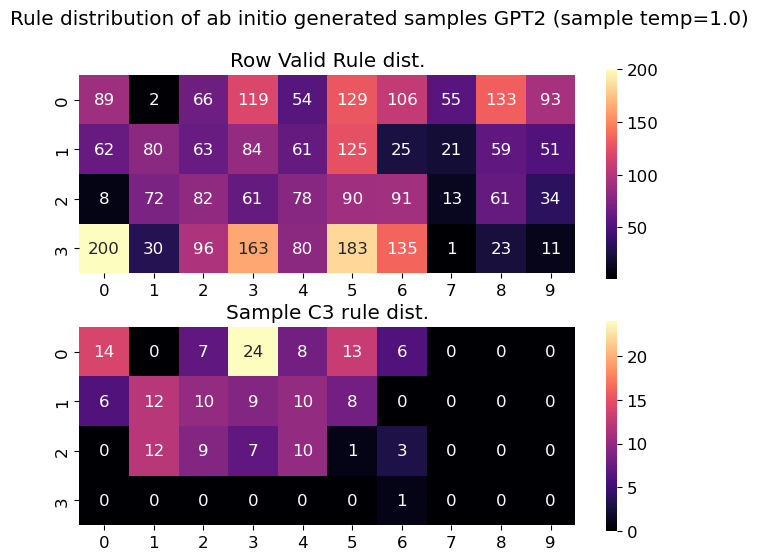

In [59]:
print("Ab initio generation, sampling: ")
temperature = 0.1
for temperature in [1.0]: #[1.0, 0.5, 0.2, 0.1]:
    eval_samples_empty = th.zeros(2048, 81, 3, dtype=th.long).to('cuda')
    eval_complete, C3_list, C2_list, rule_col_list = completion_eval(eval_samples_empty, gpt2_big_raven, num_mask=81, 
                                                device='cuda', strategy="sample", batch_size=256, temperature=temperature)
    C3_pooled = sum(C3_list, [])
    C3_pooled_arr = np.array(C3_pooled)
    rule_col_pooled = np.array(rule_col_list, dtype=object).flatten()
    rule_col_pooled = [x for x in rule_col_pooled if len(x) > 0]
    rule_col_pooled_arr = np.concatenate(rule_col_pooled)
    rule_uniq, rule_cnt = np.unique(rule_col_pooled_arr, return_counts=True)
    C3_rule_uniq, C3_rule_cnt = np.unique(C3_pooled_arr, return_counts=True)
    rule_cnt_vec = np.zeros(40).astype(int)
    C3_rule_cnt_vec = np.zeros(40).astype(int)
    rule_cnt_vec[rule_uniq] = rule_cnt
    C3_rule_cnt_vec[C3_rule_uniq] = C3_rule_cnt
    figh,axs = plt.subplots(2,1, figsize=(8,6))
    plt.subplot(2,1,1)
    sns.heatmap(rule_cnt_vec.reshape(4,10), annot=True, fmt='d', cmap='magma')
    plt.axis('image')
    plt.title("Row Valid Rule dist.")
    plt.subplot(2,1,2)
    sns.heatmap(C3_rule_cnt_vec.reshape(4,10), annot=True, fmt='d', cmap='magma')
    plt.axis('image')
    plt.title("Sample C3 rule dist.")
    plt.suptitle(f"Rule distribution of ab initio generated samples GPT2 (sample temp={temperature})")
    figh.show()

In [60]:
eval_complete_img = seqtsr2imgtsr(eval_complete, h=3, w=3, p=3, R=3)

In [62]:
th.cuda.empty_cache()

In [26]:
eval_complete_img[1].shape

torch.Size([3, 9, 9])

In [28]:
eval_complete_img.shape

torch.Size([2048, 3, 9, 9])

In [70]:
minL1dist_col = compute_min_l1_distances([eval_complete_img], attr_all_tsr, "cuda", batchsize=32, visualize=False, epoch_list=[50])
th.cuda.empty_cache()
print((minL1dist_col[50]==0).sum())

  0%|          | 0/192 [00:00<?, ?it/s]

100%|██████████| 192/192 [00:06<00:00, 29.85it/s]


tensor(0)


In [68]:
minL1dist_col_panel = compute_panel_level_min_l1_distances([eval_complete_img], attrs_one_panel, "cuda", batchsize_row=16, visualize=False, epoch_list=[50])
th.cuda.empty_cache()
print((minL1dist_col_panel[50]==0).sum())

100%|██████████| 1152/1152 [00:20<00:00, 56.37it/s]


tensor(1053)


In [69]:
minL1dist_col_panel[50].shape

torch.Size([18432, 40])

In [72]:
minL1dist_reshape = minL1dist_col_panel[50].view(2048, 3, 3,-1)

In [75]:
minval, minidx = minL1dist_reshape.min(dim=-1)

In [78]:
minval.float().mean(dim=[0,1])

tensor([24.9121, 22.2184, 19.6704])

In [51]:
minL1dist_col_panel[50].shape

tensor([[ 5,  7,  6,  ...,  8,  8,  6],
        [25, 18, 24,  ..., 24, 21, 22],
        [ 1,  1,  0,  ...,  1,  5,  0],
        ...,
        [11, 11, 11,  ..., 34, 18, 20],
        [18, 14, 18,  ..., 15, 15, 14],
        [14, 21,  7,  ..., 21, 15, 27]])

In [52]:
minL1dist_col_panel[50].min(dim=1)

torch.Size([18432, 40])

In [48]:
print((minL1dist_col_panel[50]==0).sum())

tensor(45429)


In [49]:
print((minL1dist_col_panel[50]==0).float().mean())

tensor(0.0616)


In [50]:
minL1dist_col_panel[50].shape

torch.Size([18432, 40])

In [54]:
mem_tab = compute_memorization_stats(minL1dist_col, minL1dist_col_panel, [50], expdir)

   epoch  row_memfrac row_memclass row_memcnts  panel_memfrac  \
0     50          0.0           []          []       0.295139   

                                      panel_memclass  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                       panel_memcnts  
0  [1411, 909, 611, 488, 372, 237, 170, 6, 5, 27,...  


In [57]:
mem_tab.iloc[0].panel_memcnts  

[1411,
 909,
 611,
 488,
 372,
 237,
 170,
 6,
 5,
 27,
 124,
 166,
 114,
 59,
 70,
 57,
 51,
 3,
 54,
 48,
 43,
 28,
 35,
 24,
 26,
 2,
 36,
 44,
 41,
 33,
 24,
 28,
 23,
 28,
 20,
 23]